$x(t_{l-1}) \approx N(t_{l-1}) \textbf{v}_1^{\varepsilon (l-1)}$

$\tau \Lambda = \sum \limits_{i=1}^n p_i \tau_i \lambda_1(A_i) + \sum \limits_{i,j=1}^n p_j b_{ij} \log{q_{ij}}$

In [6]:
import random
from math import log
from scipy.linalg import expm

def count_tauL(A_1, A_2, L, dist='uniform', tau1=5, shift=0):
    #duration of environments
    T = np.zeros(L)
    if dist == 'uniform':
        T = np.random.randint(0, high=2*tau1, size=L)
    elif dist == 'exponential':
        T = np.random.exponential(scale=tau1, size=L)
    elif dist == 'delta':
        #T = np.random.normal(loc=tau1, scale=tau1, size=L)
        T = np.full(L, tau1)
    #Matrix
    G = np.eye(2)
    for i in range(L):
        G = G.dot( expm(20 * A_2).dot( expm((T[i]+shift) * A_1) )  )
    #count_exp = 0
    #for i in range(L):
    #    count_exp += 20 * A_2 + T[i] * A_1
    #print(expm(count_exp))
    #G = expm(count_exp)
    tauL =  log(G.trace()) / (2*L)
    return tauL

def average_tauL(A_1, A_2, L, dist='uniform', tau1=5, shift=0, rounds=100):
    count = 0
    for i in range(rounds):
        count += count_tauL(A_1, A_2, L, dist, tau1, shift)/rounds
    return count

In [7]:
L = 10
A_1 = np.array([[2,     0.05],
                [10**(-6), -0.05]])
A_2 = np.array([[-7,    0.05],
                [10**(-6), -0.05]])

In [8]:
t1 = np.arange(3, 20, 2)
tauL_arr = np.zeros((6, len(t1)))

for i in range(len(t1)):
    print('processing ', t1[i], ' done ', round(i/len(t1)*100, 1), '%', ' left ', round(100 - i/len(t1)*100, 1), '%')
    
    shift = 0 
    tauL_arr[0][i] = average_tauL(A_1, A_2, L, 'uniform', t1[i], shift)
    tauL_arr[1][i] = average_tauL(A_1, A_2, L, 'exponential', t1[i], shift)
    tauL_arr[2][i] = average_tauL(A_1, A_2, L, 'delta', t1[i], shift)
    shift = 10    
    tauL_arr[3][i] = average_tauL(A_1, A_2, L, 'uniform', t1[i], shift)
    tauL_arr[4][i] = average_tauL(A_1, A_2, L, 'exponential', t1[i], shift)
    tauL_arr[5][i] = average_tauL(A_1, A_2, L, 'delta', t1[i], shift)

processing  3  done  0.0 %  left  100.0 %
processing  5  done  11.1 %  left  88.9 %
processing  7  done  22.2 %  left  77.8 %
processing  9  done  33.3 %  left  66.7 %
processing  11  done  44.4 %  left  55.6 %
processing  13  done  55.6 %  left  44.4 %
processing  15  done  66.7 %  left  33.3 %
processing  17  done  77.8 %  left  22.2 %
processing  19  done  88.9 %  left  11.1 %


In [9]:
from scipy.linalg import eig, inv
import cmath

lambda_a1, M_a1 = eig(A_1)
lambda_a2, M_a2 = eig(A_2)
lambda_a1.real, lambda_a2.real

(array([ 2.00000002, -0.05000002]), array([-7.00000001, -0.04999999]))

In [10]:
ind_a1 = lambda_a1.real.argmax()
ind_a2 = lambda_a2.real.argmax()
tau1 = 10
formula_tauL = 0
#i = 1    
formula_tauL += tau1 * (lambda_a1)[ind_a1].real + log(abs(np.dot(inv(M_a2)[ind_a2], M_a1[:, ind_a1])))
#i = 2
formula_tauL += 20 * (lambda_a2)[ind_a2].real + log(abs(np.dot((inv(M_a1))[ind_a1], M_a2[ind_a2])))
formula_tauL

1.0115549540233033

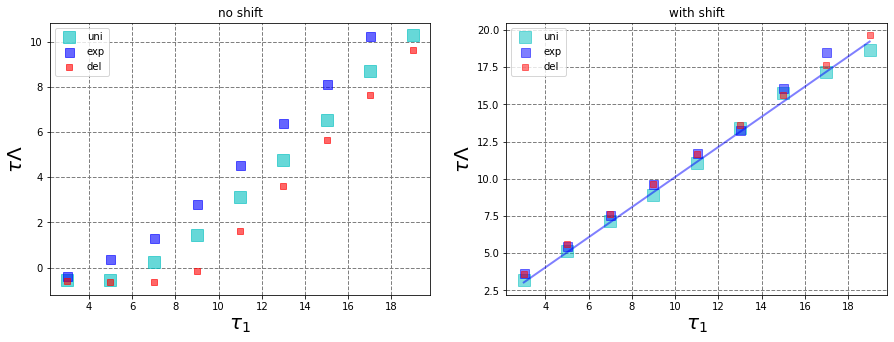

In [11]:
import matplotlib.pyplot as plt
labels=['uni', 'exp', 'del']
co = ['c', 'b', 'r']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for i in range(3):
    ax1.plot(t1, tauL_arr[i], '.',  label=labels[i], marker="s", markersize=(6-i*1.5)*2, c=co[i], alpha=0.6)
    ax2.plot(t1, tauL_arr[3+i], '.', label=labels[i], marker="s", markersize=(6-i*1.5)*2, c=co[i], alpha=0.5)
for ax in (ax1, ax2):
    ax.grid(color='grey', linestyle='--', linewidth=1)
    ax.set_xlabel(r'$\tau_1$', fontsize=20)
    ax.set_ylabel(r'$\tau\Lambda$', fontsize=20)
    ax.legend()
ax1.set_title('no shift')
ax2.set_title('with shift')
ax2.plot(t1, [t11 * formula_tauL for t11 in t1], '-', label=labels[0], lw=2, markersize=3, c=co[1], alpha=0.5)

# Simulation
Now let's try to compute our own simulation of population dynamics

In [12]:
def Simulation(x0, T, A, B, tau, nT):
    tx, xn = [0], [x0]
    n = len(tau)
    xi = random.randint(0, n-1)
    N = sum(x0)
    logN = [log(N)]
    while tx[-1] < T:
        #new time
        cur = tx[-1]
        dt = random.expovariate(1/tau[xi])        
        ch = min(dt, T-cur)
        for i in range(nT):
            tx.append(cur + ch*(i+1)/nT)
        #new population        
        M = expm(A[:, :, xi] * (tx[-1] - tx[-2]))
        for k in range(nT):
            xTil = M.dot(xn[-1])
            s = abs(np.sum(xTil))
            logN.append(logN[-1] + log(s))
            xn = np.concatenate((xn, np.array([xTil/s])), axis=0)
        new_xi = np.random.multinomial(1, B[:, xi])
        xi = np.argmax(new_xi)
    return tx, xn, logN, xi

In [13]:
n = 5
Hm = (random.random()+ 0.5)
tau = np.random.sample(n) + 5
B = np.random.sample((n, n))
A = np.zeros((n, n, n))
f = np.random.sample((n, n)) + 1.5 + np.diag(10 * np.random.sample(n) + 0.5)
for k in range(n):
    B[k, k] = 0
    B[:, k] /= sum(B[:, k])
    A[:, :, k] = np.diag(f[:, k] - Hm)
    A[k, :, k] = np.full(n, Hm)
    A[k, k, k] = f[k, k]
evals, evecs =  eig(B)
evec = evecs[:, evals.real.argmax()]
T = 1000
x0 = np.full(n, 1/n)
nT = 10

In [14]:
tx_R, xn_R, logN_R, xi_R = Simulation(x0, T, A, B, tau, nT)

In [15]:
DeltaR = f.copy()
for k in range(n):
    DeltaR[:, k] = DeltaR[k, k] - DeltaR[:, k]
one = np.sum(evec * tau * np.diagonal(f))
two = np.sum(B * np.log(1+DeltaR/Hm) * evec)
three = np.sum(evec * tau)
gammaR = (one - two) / three

Text(0.5, 1.0, 'Simulation of R-switching for 5 phenotypes with random initial conditions')

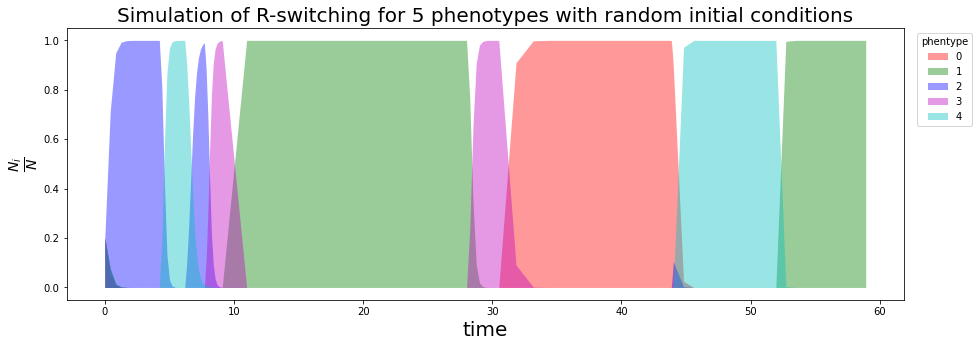

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
c = ['r', 'g', 'b', 'm', 'c']
for i in range(n):
    arr = xn_R[:100, i]
    t = tx_R[:100]
    ax1.fill_between(t, arr, label=str(i), lw=0, alpha=0.4, color=c[i])
ax1.legend(title='phentype', bbox_to_anchor=(1.01, 1), loc='upper left')
ax1.set_xlabel('time', fontsize = 20)
ax1.set_ylabel(r'$\frac{N_i}{N}$', fontsize = 20)
#ax1.set_yscale('log')
plt.title('Simulation of R-switching for 5 phenotypes with random initial conditions', fontsize = 20)

In [17]:
n = 5
H = (0.5 * np.random.sample((n, n)) + 0.5) /n/5
H = H - np.diag(sum(H))
tau = np.random.sample(n) + 3
B = np.random.sample((n, n))
A = np.zeros((n, n, n))
f = np.random.sample((n, n)) + 0.5 + np.diag(10 * np.random.sample(n) + 0.5)
for k in range(n):
    B[k, k] = 0
    B[:, k] /= sum(B[:, k])
    A[:, :, k] = np.diag(f[:, k]) + H
    
evals, evecs =  eig(B)
evec = evecs[:, evals.real.argmax()]
T = 1000
x0 = np.full(n, 1/n)
nT = 10

In [18]:
tx_S, xn_S, logN_S, xi_S = Simulation(x0, T, A, B, tau, nT)

In [19]:
divider = np.ones((len(f), len(f)))
Delta = f.copy()
for k in range(n):
    Delta[:, k] = Delta[k, k] - Delta[:, k]
DeltaS = divider / (divider / Delta + divider / Delta.T)

one = np.sum(evec* tau * np.diagonal(f))
two = np.sum(evec * tau * np.diagonal(H))
three = np.sum(B * np.log(divider + DeltaS / H) * evec)
four = np.sum(evec * tau)

gammaS = (one - two - three) / four

<ipython-input-19-2b04b353a84c>:5: RuntimeWarning: divide by zero encountered in true_divide
  DeltaS = divider / (divider / Delta + divider / Delta.T)


Text(0.5, 1.0, 'Simulation of S-switching for 5 phenotypes with random initial conditions')

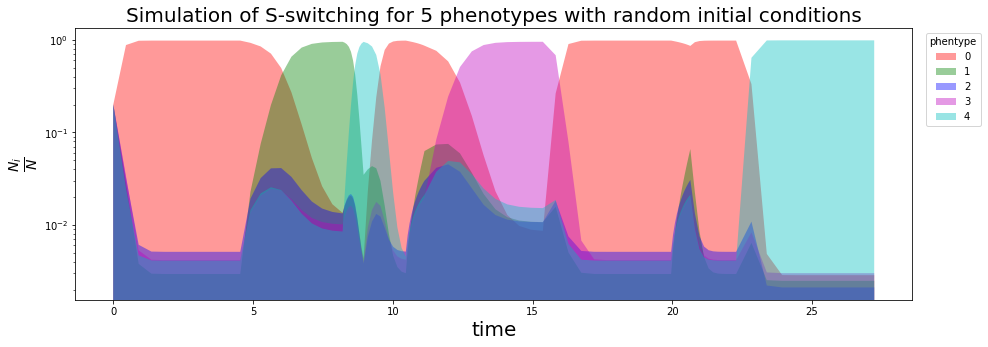

In [20]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
c = ['r', 'g', 'b', 'm', 'c']
for i in range(n):
    arr = xn_S[:100, i]
    t = tx_S[:100]
    ax1.fill_between(t, arr, label=str(i), lw=0, alpha=0.4, color=c[i])
ax1.legend(title='phentype', bbox_to_anchor=(1.01, 1), loc='upper left')
ax1.set_xlabel('time', fontsize = 20)
ax1.set_ylabel(r'$\frac{N_i}{N}$', fontsize = 20)
ax1.set_yscale('log')
plt.title('Simulation of S-switching for 5 phenotypes with random initial conditions', fontsize = 20)

Text(0.5, 1.0, 'Simulation of S-switching for 5 phenotypes with random initial conditions')

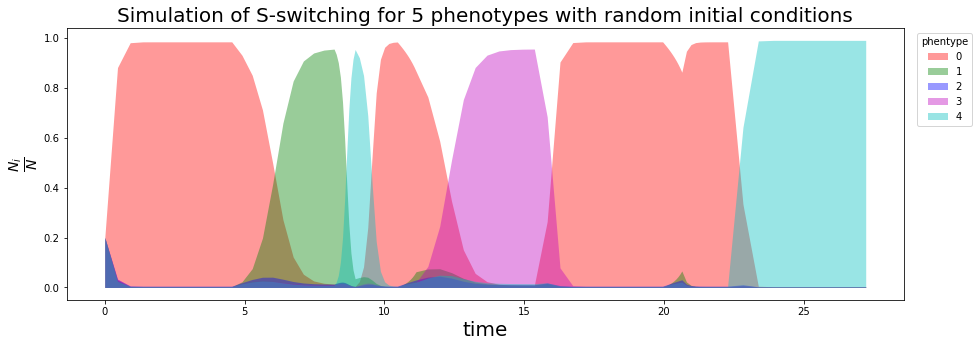

In [21]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
c = ['r', 'g', 'b', 'm', 'c']
for i in range(n):
    arr = xn_S[:100, i]
    t = tx_S[:100]
    ax1.fill_between(t, arr, label=str(i), lw=0, alpha=0.4, color=c[i])
ax1.legend(title='phentype', bbox_to_anchor=(1.01, 1), loc='upper left')
ax1.set_xlabel('time', fontsize = 20)
ax1.set_ylabel(r'$\frac{N_i}{N}$', fontsize = 20)
#ax1.set_yscale('log')
plt.title('Simulation of S-switching for 5 phenotypes with random initial conditions', fontsize = 20)

In [22]:
n = 15
Hm = (random.random()+ 0.5)
tau = np.random.sample(n) + 5
B = np.random.sample((n, n))
A = np.zeros((n, n, n))
f = np.random.sample((n, n)) + 1.5 + np.diag(10 * np.random.sample(n) + 0.5)
for k in range(n):
    B[k, k] = 0
    B[:, k] /= sum(B[:, k])
    A[:, :, k] = np.diag(f[:, k] - Hm)
    A[k, :, k] = np.full(n, Hm)
    A[k, k, k] = f[k, k]
evals, evecs =  eig(B)
evec = evecs[:, evals.real.argmax()]
T = 1000
x0 = np.full(n, 1/n)
nT = 10

In [23]:
tx_R, xn_R, logN_R, xi_R = Simulation(x0, T, A, B, tau, nT)

In [24]:
DeltaR = f.copy()
for k in range(n):
    DeltaR[:, k] = DeltaR[k, k] - DeltaR[:, k]
one = np.sum(evec * tau * np.diagonal(f))
two = np.sum(B * np.log(1+DeltaR/Hm) * evec)
three = np.sum(evec * tau)
gammaR = (one - two) / three

In [25]:
H = (0.5 * np.random.sample((n, n)) + 0.5) /n/5
H = H - np.diag(sum(H))
tau = np.random.sample(n) + 3
B = np.random.sample((n, n))
A = np.zeros((n, n, n))
f = np.random.sample((n, n)) + 0.5 + np.diag(10 * np.random.sample(n) + 0.5)
for k in range(n):
    B[k, k] = 0
    B[:, k] /= sum(B[:, k])
    A[:, :, k] = np.diag(f[:, k]) + H
    
evals, evecs =  eig(B)
evec = evecs[:, evals.real.argmax()]
T = 1000
x0 = np.full(n, 1/n)
nT = 10

In [26]:
tx_S, xn_S, logN_S, xi_S = Simulation(x0, T, A, B, tau, nT)

In [27]:
divider = np.ones((len(f), len(f)))
Delta = f.copy()
for k in range(n):
    Delta[:, k] = Delta[k, k] - Delta[:, k]
DeltaS = divider / (divider / Delta + divider / Delta.T)

one = np.sum(evec* tau * np.diagonal(f))
two = np.sum(evec * tau * np.diagonal(H))
three = np.sum(B * np.log(divider + DeltaS / H) * evec)
four = np.sum(evec * tau)

gammaS = (one - two - three) / four

<ipython-input-27-2b04b353a84c>:5: RuntimeWarning: divide by zero encountered in true_divide
  DeltaS = divider / (divider / Delta + divider / Delta.T)


C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'S')

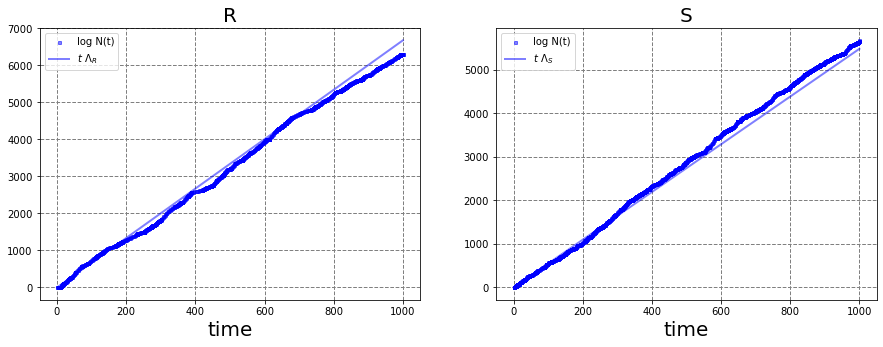

In [28]:
import matplotlib.pyplot as plt
labels=[r'$t\ \Lambda_R$', 'log N(t)', r'$t\ \Lambda_S$']
co = ['c', 'b', 'r']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(tx_R, logN_R, '.',  label=labels[1], marker="s", markersize=3, c=co[1], alpha=0.5)
ax2.plot(tx_S, logN_S, '.', label=labels[1], marker="s", markersize=3, c=co[1], alpha=0.5)

ax1.plot(tx_R, [txi * gammaR for txi in tx_R], '-',  label=labels[0], lw=2, c=co[1], alpha=0.5)
ax2.plot(tx_S, [txi * gammaS for txi in tx_S], '-', label=labels[2], lw=2, markersize=3, c=co[1], alpha=0.5)
for ax in (ax1, ax2):
    ax.grid(color='grey', linestyle='--', linewidth=1)
    ax.set_xlabel(r'time', fontsize=20)
    #ax.set_ylabel(r'$\Lambda$', fontsize=20)
    ax.legend()
ax1.set_title('R', fontsize=20)
ax2.set_title('S', fontsize=20)

Text(0.5, 1.0, 'S')

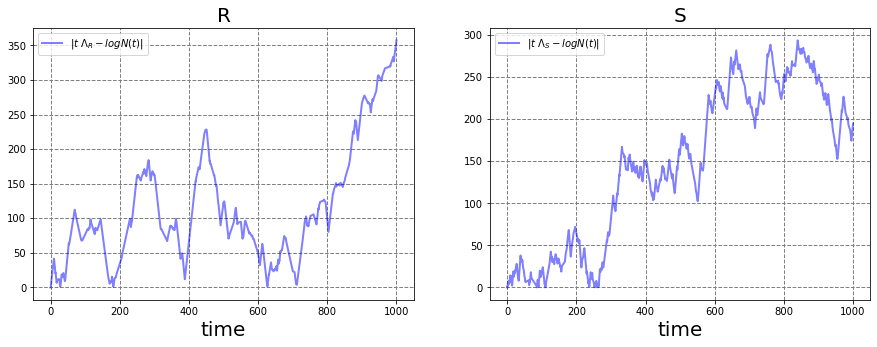

In [37]:
import matplotlib.pyplot as plt
labels=[r'$|t\ \Lambda_R-log N(t)|$', r'$|t\ \Lambda_S-log N(t)|$']
co = ['c', 'b', 'r']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
LR=np.array([txi * gammaR for txi in tx_R])
LS=np.array([txi * gammaS for txi in tx_S])
ax1.plot(tx_R, abs(logN_R-LR), '-',  label=labels[0], lw=2, c=co[1], alpha=0.5)
ax2.plot(tx_S, abs(logN_S-LS), '-', label=labels[1], lw=2, markersize=3, c=co[1], alpha=0.5)
for ax in (ax1, ax2):
    ax.grid(color='grey', linestyle='--', linewidth=1)
    ax.set_xlabel(r'time', fontsize=20)
    #ax.set_ylabel(r'$\Lambda$', fontsize=20)
    ax.legend()
ax1.set_title('R', fontsize=20)
ax2.set_title('S', fontsize=20)